# Data Statistics

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from htc.fonts.set_font import set_font
from htc.settings_seg import settings_seg
from htc.utils.helper_functions import basic_statistics
from htc.utils.sqldf import sqldf

set_font()
import plotly.io as pio

pio.kaleido.scope.mathjax = None

In [2]:
df = basic_statistics("2021_02_05_Tivita_multiorgan_semantic", "pigs_semantic-only_5foldsV2.json")
labels = [l for l in settings_seg.label_colors_paper.keys() if l not in ["background", "invalid"]]
pigs = df["subject_name"].unique().tolist()

labels_plotly = [settings_seg.labels_paper_renaming.get(l, l) for l in labels]
labels_mpl = [l.replace("<br>", "\n") for l in labels_plotly]

## Heatmap

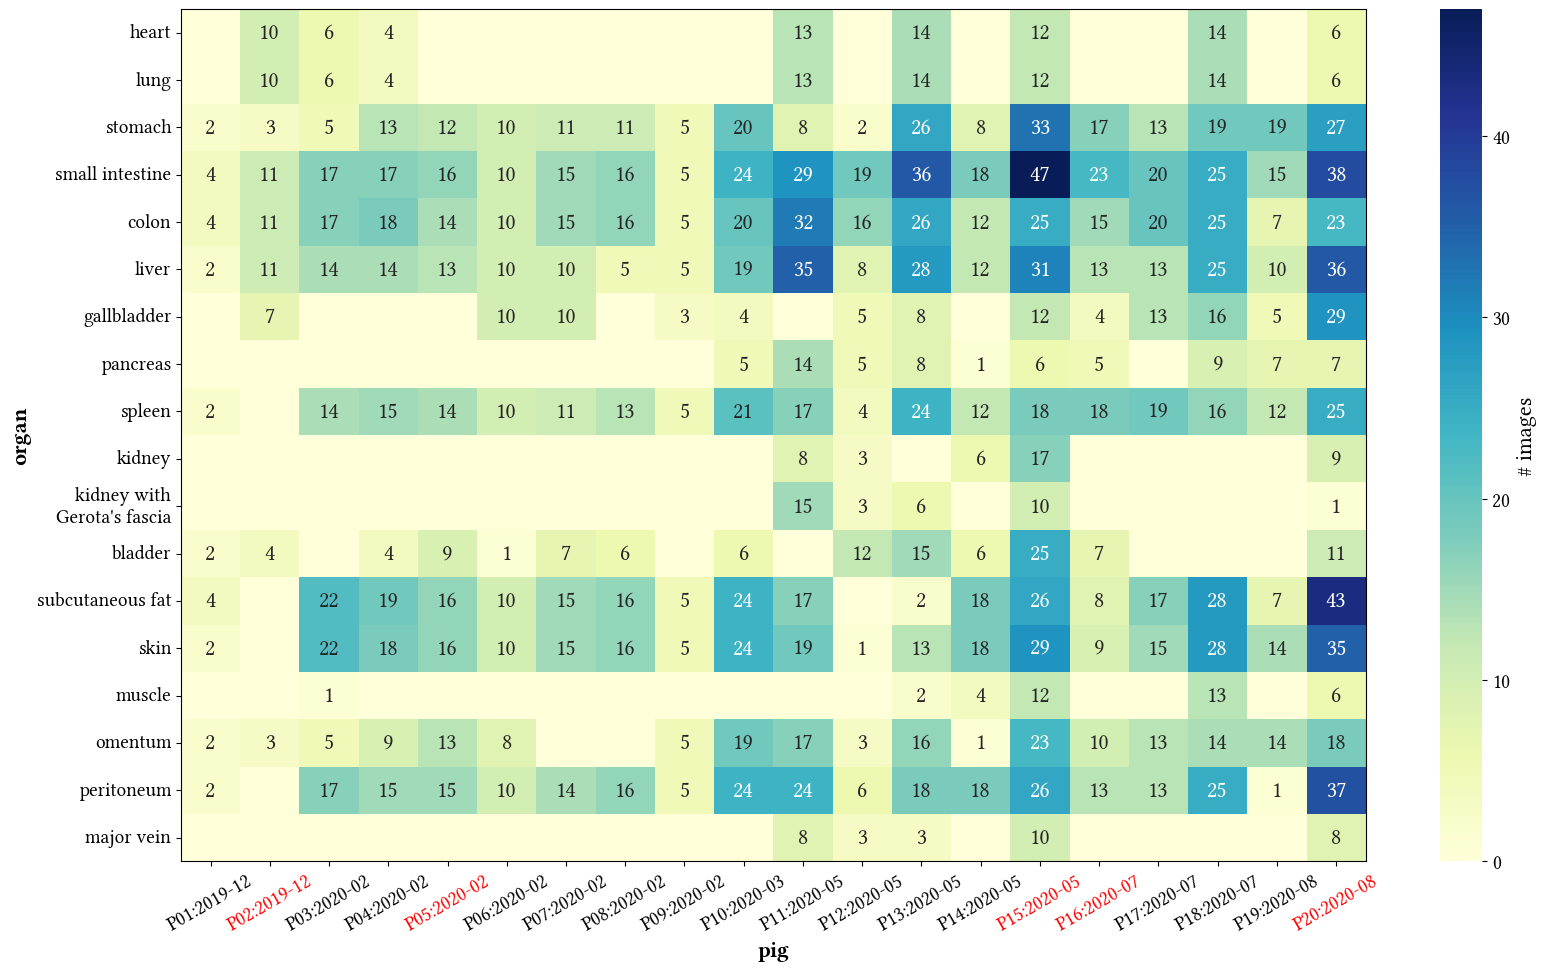

In [3]:
pigs = df["subject_name"].unique().tolist()
test_pigs = df.query('set_type == "test"')["subject_name"].unique()
counts = np.zeros((len(labels), len(pigs)), dtype=np.int64)

for i, row in df.iterrows():
    if row["label_name"] in labels:
        label_index = labels.index(row["label_name"])
        pig_index = pigs.index(row["subject_name"])
        counts[label_index, pig_index] += 1

df_pig_dates = sqldf(
    """
    SELECT subject_name, MIN(timestamp) AS date
    FROM df
    GROUP BY subject_name
    ORDER BY subject_name
"""
)
df_pig_dates["date_tps"] = pd.to_datetime(df_pig_dates.date.values, format="%Y_%m_%d_%H_%M_%S")
pig_dates = []
for i, row in df_pig_dates.iterrows():
    pig_nr = pigs.index(row["subject_name"]) + 1
    pig_dates.append(f'P{pig_nr:02d}:{row["date_tps"].year}-{row["date_tps"].month:02d}')

assert counts.shape[0] == len(labels) and counts.shape[1] == len(pigs), "Dimension mismatch"
assert len(pigs) == len(pig_dates)

fig, ax = plt.subplots(tight_layout=True, figsize=(17, 10), dpi=100, edgecolor="k")
text = np.vectorize(lambda x: "" if x == 0 else f"{x}")(counts)
hmap = sns.heatmap(
    counts,
    xticklabels=pig_dates,
    yticklabels=labels_mpl,
    annot=text,
    fmt="s",
    cmap="YlGnBu",
    cbar_kws={"label": "# images"},
    ax=ax,
)
ax.tick_params(axis="both")

# Highlight test set
for i, t in enumerate(ax.xaxis.get_ticklabels()):
    t.set_rotation(30)
    if pigs[i] in test_pigs:
        t.set_color("red")

# Make frame visible
for _, spine in hmap.spines.items():
    spine.set_visible(True)

ax.set_xlabel("pig", fontweight="bold")
ax.set_ylabel("organ", fontweight="bold")
fig.savefig(settings_seg.paper_dir / "data_statistics_heatmap.pdf")

## Barchart

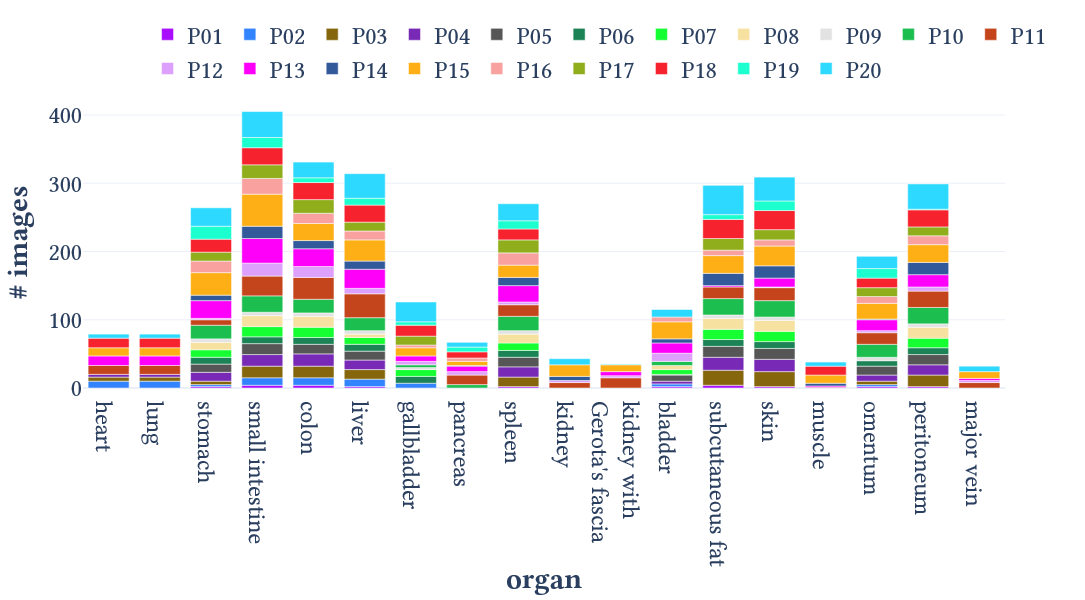

In [4]:
df_labels = sqldf(
    """
    SELECT label_name, subject_name AS `pig identifier`, COUNT(*) AS n_images, SUM(n_pixels) AS n_pixels
    FROM df
    GROUP BY label_name, subject_name
"""
).query("label_name in @labels")
df_labels.replace(pigs, [f"P{pigs.index(p)+1:02d}" for p in pigs], inplace=True)
df_labels.replace(labels, labels_plotly, inplace=True)
df_labels.sort_values(by=["pig identifier"], inplace=True)

fig = px.bar(
    df_labels,
    x="label_name",
    y="n_images",
    color="pig identifier",
    color_discrete_sequence=px.colors.qualitative.Alphabet,
)
fig.layout.xaxis.categoryorder = "array"
fig.layout.xaxis.categoryarray = labels_plotly
fig.layout.height = 600
fig.layout.width = 2000
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(yaxis_title="<b># images</b>", xaxis_title=dict(text="<b>organ</b>", standoff=0))
fig.update_layout(legend=dict(x=0.07, y=1.02, yanchor="bottom", orientation="h", title=""))
fig.update_layout(template="plotly_white", font_family="Libertinus Serif", font_size=24)
fig.write_image(settings_seg.paper_dir / "data_statistics_bar.pdf")
fig.show()

## Numbers

In [5]:
sqldf(
    """
    SELECT label_name, COUNT(DISTINCT `pig identifier`) AS n_pigs, SUM(n_images)
    FROM df_labels
    GROUP BY label_name
"""
)

,label_name,n_pigs,SUM(n_images)
0,bladder,14,115
1,colon,20,331
2,gallbladder,13,126
3,heart,8,79
4,kidney,5,43
5,kidney with<br>Gerota's fascia,5,35
6,liver,20,314
7,lung,8,79
8,major vein,5,32
9,muscle,6,38


In [6]:
sqldf(
    """
    SELECT set_type, COUNT(DISTINCT subject_name) AS n_pigs, COUNT(DISTINCT timestamp) AS n_images
    FROM df
    GROUP BY set_type
"""
)

,set_type,n_pigs,n_images
0,test,5,166
1,train,15,340


Ratio of background pixels

In [7]:
df_background = df.query("label_name not in @labels")
sqldf(
    """
    SELECT timestamp, CAST(SUM(n_pixels) AS FLOAT) / 307200 AS pixel_ratio
    FROM df_background
    GROUP BY timestamp
"""
)["pixel_ratio"].mean()

0.48073018311511867

Labels which are available for all pigs in the training set and are hence suitable for the dataset size experiment

In [8]:
sqldf(
    """
    SELECT label_name, COUNT(DISTINCT subject_name) as n_pigs
    FROM df
    WHERE set_type = 'train'
    GROUP BY label_name
    ORDER BY n_pigs
"""
).query("label_name in @labels")

,label_name,n_pigs
1,kidney,3
2,kidney_with_Gerotas_fascia,3
3,major_vein,3
5,muscle,4
6,heart,5
7,lung,5
10,pancreas,7
12,bladder,9
13,gallbladder,9
18,omentum,13


In [9]:
df.query('label_name == "major_vein"')["n_pixels"].mean()

4192.15625